In [23]:
# Блок 1 - импорт
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay

# SMOTE для балансировки классов
from imblearn.over_sampling import SMOTE

import os
os.environ["LOKY_MAX_CPU_COUNT"] = "4"

In [24]:
# Блок 2 - загрузка данных
data = pd.read_excel('class.xlsx')
df = pd.DataFrame(data)

print(df.head())
print("Колонки:", df.columns.tolist())

   Yн  Zн  Yс  Zс  Yв  Zв      U      Т
0  35   2  27   1  29   1  10.54  79.01
1  28   1  26   1  28   1  10.83  66.18
2  30   1  26   1  26   1  10.63  77.86
3  26   1  25   1  25   1  10.72  73.63
4  32   1  27   1  27   1  10.73  68.97
Колонки: ['Yн', 'Zн', 'Yс', 'Zс', 'Yв', 'Zв', 'U', 'Т']


In [25]:
# Блок 3 - формирование признаков и целевой переменной
X = df[['Yн', 'U', 'Т']]
y = df['Zн']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    stratify=y,
    test_size=0.25,
    random_state=73
)

print(f"Всего классов: {len(y.unique())}")
print("Распределение классов:\n", y.value_counts().sort_index())

Всего классов: 3
Распределение классов:
 Zн
1    72
2    25
3     3
Name: count, dtype: int64


In [26]:
# Блок 4 - нормализация признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [27]:
from imblearn.over_sampling import SMOTE
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

def balance_classes(X, y):
    # Рассчитываем веса классов
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
    class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
    
    # Используем SMOTE для балансировки
    smote = SMOTE(k_neighbors=1, random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    
    return X_resampled, y_resampled, class_weight_dict

# Применение
print("До балансировки:", np.bincount(y_train))
X_train_balanced, y_train_balanced, class_weights = balance_classes(X_train_scaled, y_train)
print("После балансировки:", np.bincount(y_train_balanced))

# Выводим веса классов
print("Веса классов:", class_weights)


До балансировки: [ 0 54 19  2]
После балансировки: [ 0 54 54 54]
Веса классов: {0: np.float64(0.46296296296296297), 1: np.float64(1.3157894736842106), 2: np.float64(12.5)}


In [28]:
# Блок 5 - подбор гиперпараметров через GridSearchCV
param_grid = {
    'activation': ['relu'],
    'alpha': [0.001, 0.01, 0.1],
    'hidden_layer_sizes': [(4,), (5,), (6,)],
    'learning_rate': ['constant'],
    'learning_rate_init': [1e-5, 1e-4, 0.001, 0.01, 0.1],
    'solver': ['lbfgs'],
    'tol': [1e-6, 1e-5, 1e-4],
    'early_stopping': [True],
    'max_iter': [500]
}



cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=MLPClassifier(random_state=42),
    param_grid=param_grid,
    scoring='f1_macro',
    cv=cv,
    n_jobs=-1,
    verbose=2
)

In [29]:
# Блок 6 - обучение лучшей модели
print("\nПодбор гиперпараметров (по f1_macro)...")
grid_search.fit(X_train_balanced, y_train_balanced)


Подбор гиперпараметров (по f1_macro)...
Fitting 5 folds for each of 135 candidates, totalling 675 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=MLPClassifier(random_state=42), n_jobs=-1,
             param_grid={'activation': ['relu'], 'alpha': [0.001, 0.01, 0.1],
                         'early_stopping': [True],
                         'hidden_layer_sizes': [(4,), (5,), (6,)],
                         'learning_rate': ['constant'],
                         'learning_rate_init': [1e-05, 0.0001, 0.001, 0.01,
                                                0.1],
                         'max_iter': [500], 'solver': ['lbfgs'],
                         'tol': [1e-06, 1e-05, 0.0001]},
             scoring='f1_macro', verbose=2)

In [30]:
# Блок 7 - результаты подбора
print("Лучшие параметры:\n", grid_search.best_params_)
print("F1-мера на кросс-валидации:", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)

Лучшие параметры:
 {'activation': 'relu', 'alpha': 0.001, 'early_stopping': True, 'hidden_layer_sizes': (5,), 'learning_rate': 'constant', 'learning_rate_init': 1e-05, 'max_iter': 500, 'solver': 'lbfgs', 'tol': 1e-06}
F1-мера на кросс-валидации: 0.9936507936507937


In [31]:
# Блок 8 - метрики
print("\nОтчёт по классификации:")
print(classification_report(y_test, y_pred))

f1 = f1_score(y_test, y_pred, average='weighted')
print(f"\nF1-мера (weighted): {f1:.4f}")


Отчёт по классификации:
              precision    recall  f1-score   support

           1       1.00      0.94      0.97        18
           2       0.86      1.00      0.92         6
           3       1.00      1.00      1.00         1

    accuracy                           0.96        25
   macro avg       0.95      0.98      0.96        25
weighted avg       0.97      0.96      0.96        25


F1-мера (weighted): 0.9610


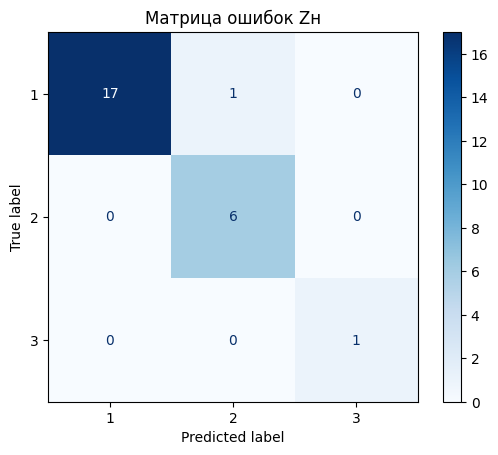

In [32]:
# Блок 9 - матрица ошибок
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(1, cm.shape[0] + 1))
disp.plot(cmap='Blues')
plt.title("Матрица ошибок Zн")
plt.show()

In [33]:
# Блок 10 - сравнение предсказаний
test_comparison_model = pd.DataFrame({
    "Zн (истинное)": y_test.values,
    "Zн (предсказанное)": y_pred
})
print("\nСравнение предсказаний:")
print(test_comparison_model)


Сравнение предсказаний:
    Zн (истинное)  Zн (предсказанное)
0               1                   1
1               2                   2
2               1                   2
3               1                   1
4               1                   1
5               1                   1
6               1                   1
7               1                   1
8               2                   2
9               1                   1
10              1                   1
11              1                   1
12              1                   1
13              1                   1
14              1                   1
15              1                   1
16              2                   2
17              2                   2
18              2                   2
19              1                   1
20              1                   1
21              2                   2
22              1                   1
23              3                   3
24              1        